In [1]:
import json
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [2]:
rc("font", size=18, weight="normal")

# Global variables

In [3]:
DATA_DIRECTORY = Path("data", "hamiltonians_ala_4_residues_single_diastereomer")

# Load data

## Load all problems and results

In [4]:
results = []
for hamiltonian_dir in Path(DATA_DIRECTORY).glob("hamiltonian*"):
    # FIXME: "max_energy" and "random_sampling_energy" key should have been in optimization result
    with open(Path(hamiltonian_dir, "hamiltonian.json"), "r") as f:
        hamiltonian = json.load(f)
    energies = np.array(hamiltonian["hamiltonian"])
    valid_energies = energies[~np.isclose(energies, hamiltonian["invalid_energy"])]
    valid_energies_without_clash = energies[np.isclose(hamiltonian["clashes"], 0)]
    max_energy = np.max(valid_energies)
    random_sampling_energy = np.mean(valid_energies)
    random_sampling_energy_without_clash = np.mean(valid_energies_without_clash)
    clash_penalty = hamiltonian["clash_penalty"]
    for optimization_file in Path(hamiltonian_dir).glob("optimization*"):
        with optimization_file.open("r") as f:
            optimization_result = json.load(f)
        if optimization_result["clash_penalty"] != clash_penalty:
            print(f"result {optimization_file} has unexpected clash penalty!")
            continue
        min_energy = optimization_result["min_energy"]
        min_energy_without_clash = optimization_result["min_energy_without_clash"]
        if "reuse-results" not in optimization_result:
            optimization_result["reuse-results"] = False
        results.append({
            "num_residues": optimization_result["num_residues"],
            "p": optimization_result["p"],
            "clash_penalty": optimization_result["clash_penalty"],
            "min_energy": min_energy,
            "min_energy_without_clash": min_energy_without_clash,
            "max_energy": max_energy,
            "random_sampling_energy": random_sampling_energy,
            "random_sampling_energy_without_clash": random_sampling_energy_without_clash,
            "method": ("init_adiabatic" if optimization_result["reuse-results"] else "adiabatic") if optimization_result["init-method"] == "adiabatic" else "random",
            "reuse-results": optimization_result["reuse-results"],
            "num_trials": optimization_result["num-trials"],
            "maxiter": optimization_result["maxiter"],
            "runtime": optimization_result["runtime"] / optimization_result["num-trials"],
            "expected_energy": optimization_result["angles"][0]["expected_energy"],
            "expected_energy_without_clash": optimization_result["angles"][0]["expected_energy_without_clash"],
            "clash_probability": optimization_result["angles"][0]["clash_probability"],
            "min_energy_probability": optimization_result["angles"][0]["min_energy_probability"],
            "min_energy_without_clash_probability": optimization_result["angles"][0]["min_energy_without_clash_probability"],
            "file": optimization_file
        })
        if optimization_result["init-method"] == "adiabatic" and not optimization_result["reuse-results"]:
            results.append({
                "num_residues": optimization_result["num_residues"],
                "p": optimization_result["p"],
                "clash_penalty": optimization_result["clash_penalty"],
                "min_energy": min_energy,
                "max_energy": max_energy,
                "random_sampling_energy": random_sampling_energy,
                "random_sampling_energy_without_clash": random_sampling_energy_without_clash,
                "min_energy_without_clash": min_energy_without_clash,
                "method": "init_adiabatic",
                "reuse-results": optimization_result["reuse-results"],
                "num_trials": optimization_result["num-trials"],
                "maxiter": optimization_result["maxiter"],
                "runtime": optimization_result["runtime"] / optimization_result["num-trials"],
                "expected_energy": optimization_result["angles"][1]["expected_energy"],
                "expected_energy_without_clash": optimization_result["angles"][1]["expected_energy_without_clash"],
                "clash_probability": optimization_result["angles"][1]["clash_probability"],
                "min_energy_probability": optimization_result["angles"][1]["min_energy_probability"],
                "min_energy_without_clash_probability": optimization_result["angles"][1]["min_energy_without_clash_probability"],
                "file": optimization_file
            })
results_df = pd.DataFrame(results)

## Select best results

### Distinguish between results using parameter extrapolations and others

In [5]:
result_fields = ["num_residues", "p", "clash_penalty", "method"]
best_results_df = results_df \
    .sort_values("expected_energy") \
    .drop_duplicates(result_fields, keep="first") \
    .sort_values(result_fields)
best_results_extrap_df = results_df \
    .query("`reuse-results` == True") \
    .sort_values("expected_energy") \
    .drop_duplicates(result_fields, keep="first") \
    .sort_values(result_fields)
best_results_no_extrap_df = results_df \
    .query("`reuse-results` == False") \
    .sort_values("expected_energy") \
    .drop_duplicates(result_fields, keep="first") \
    .sort_values(result_fields)
best_results_df = best_results_df[result_fields + ["runtime", "min_energy", "min_energy_without_clash", "max_energy", "random_sampling_energy", "random_sampling_energy_without_clash", "expected_energy", "expected_energy_without_clash", "clash_probability", "min_energy_probability", "min_energy_without_clash_probability", "file"]]
best_results_no_extrap_df = best_results_no_extrap_df[result_fields + ["runtime", "min_energy", "min_energy_without_clash", "max_energy", "random_sampling_energy", "random_sampling_energy_without_clash", "expected_energy", "expected_energy_without_clash", "clash_probability", "min_energy_probability", "min_energy_without_clash_probability", "file"]]

results_count = results_df.groupby(result_fields).agg({"expected_energy_without_clash": "min", "num_trials": "sum", "runtime": "mean"}).reset_index()

### Distinguish between both extrapolation/no extrapolation and the parameter initialization methods (random initialization, adiabatic schedule, optimize starting from adiabatic schedule)

In [6]:
selected_random_df = best_results_df.query(f"method == 'random' & clash_penalty == 1000")
selected_adiabatic_df = best_results_df.query(f"method == 'adiabatic' & clash_penalty == 1000")
selected_init_adiabatic_df = best_results_df.query(f"method == 'init_adiabatic' & clash_penalty == 1000")
selected_extrap_random_df = best_results_extrap_df.query(f"method == 'random' & clash_penalty == 1000")
selected_extrap_init_adiabatic_df = best_results_extrap_df.query(f"method == 'init_adiabatic' & clash_penalty == 1000")
selected_no_extrap_random_df = best_results_no_extrap_df.query(f"method == 'random' & clash_penalty == 1000")
selected_no_extrap_adiabatic_df = best_results_no_extrap_df.query(f"method == 'adiabatic' & clash_penalty == 1000")
selected_no_extrap_init_adiabatic_df = best_results_no_extrap_df.query(f"method == 'init_adiabatic' & clash_penalty == 1000")

# Generate paper plots

## Comparing QAOA angle initialization methods

### Energy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


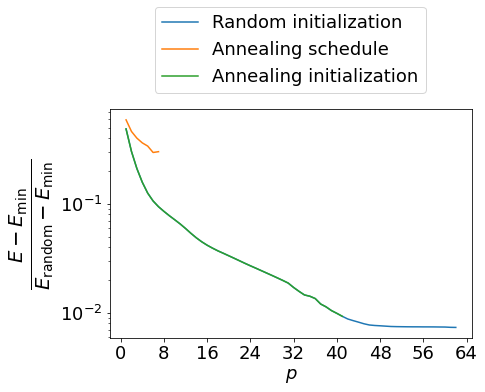

In [7]:
fig, ax = plt.subplots(figsize=(6.5, 4.2))
ax.semilogy(selected_random_df["p"], (selected_random_df["expected_energy"] - selected_random_df["min_energy"]) / (selected_random_df["random_sampling_energy"] - selected_random_df["min_energy"]), "-", ms=0, label="Random initialization")
ax.semilogy(selected_adiabatic_df["p"], (selected_adiabatic_df["expected_energy"] - selected_adiabatic_df["min_energy"]) / (selected_adiabatic_df["random_sampling_energy"] - selected_adiabatic_df["min_energy"]), "-", ms=0, label="Annealing schedule")
ax.semilogy(selected_init_adiabatic_df["p"], (selected_init_adiabatic_df["expected_energy"] - selected_init_adiabatic_df["min_energy"]) / (selected_init_adiabatic_df["random_sampling_energy"] - selected_init_adiabatic_df["min_energy"]), "-", ms=0, label="Annealing initialization")
ax.set_xlabel("$p$")
ax.set_ylabel("$\\frac{E - E_{\mathrm{min}}}{E_{\mathrm{random}} - E_{\mathrm{min}}}$", fontsize=28)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.legend(loc="upper right", bbox_to_anchor=(0.82, 1.25))
#fig.tight_layout()
fig.savefig(Path("figures", "small_peptide_sampling", f"energy_optimize__num_residues=4.eps"), bbox_inches="tight")

### Energy, conditioned on no clashes

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


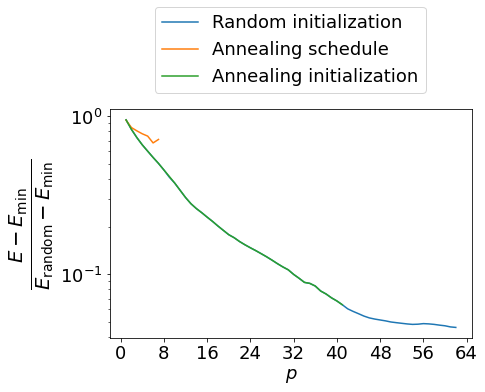

In [8]:
fig, ax = plt.subplots(figsize=(6.5, 4.2))
ax.semilogy(selected_random_df["p"], (selected_random_df["expected_energy_without_clash"] - selected_random_df["min_energy_without_clash"]) / (selected_random_df["random_sampling_energy_without_clash"] - selected_random_df["min_energy_without_clash"]), "-", ms=0, label="Random initialization")
ax.semilogy(selected_adiabatic_df["p"], (selected_adiabatic_df["expected_energy_without_clash"] - selected_adiabatic_df["min_energy_without_clash"]) / (selected_adiabatic_df["random_sampling_energy_without_clash"] - selected_adiabatic_df["min_energy_without_clash"]), "-", ms=0, label="Annealing schedule")
ax.semilogy(selected_init_adiabatic_df["p"], (selected_init_adiabatic_df["expected_energy_without_clash"] - selected_init_adiabatic_df["min_energy_without_clash"]) / (selected_init_adiabatic_df["random_sampling_energy_without_clash"] - selected_init_adiabatic_df["min_energy_without_clash"]), "-", ms=0, label="Annealing initialization")
ax.set_xlabel("$p$")
ax.set_ylabel("$\\frac{E - E_{\mathrm{min}}}{E_{\mathrm{random}} - E_{\mathrm{min}}}$", fontsize=28)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.legend(loc="upper right", bbox_to_anchor=(0.82, 1.25))
#fig.tight_layout()
fig.savefig(Path("figures", "small_peptide_sampling", f"energy_without_clash_optimize__num_residues=4.eps"), bbox_inches="tight")

## Suppression of clashes

### For random angle initialization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


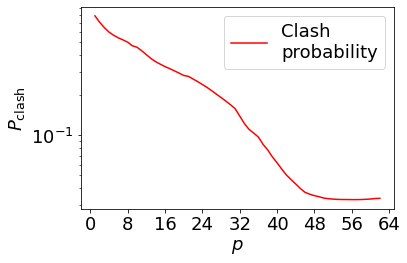

In [9]:
fig, ax = plt.subplots()
ax.semilogy(selected_random_df["p"], selected_random_df["clash_probability"], "r-", label="Clash\nprobability")
ax.set_xlabel("$p$")
ax.set_ylabel("$P_{\mathrm{clash}}$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(loc="upper right")
fig.tight_layout()
fig.savefig(Path("figures", "small_peptide_sampling", f"energy_optimize_clash_probability__method=random__num_residues=4.eps"))

### For angles constrained to follow adiabatic schedule

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


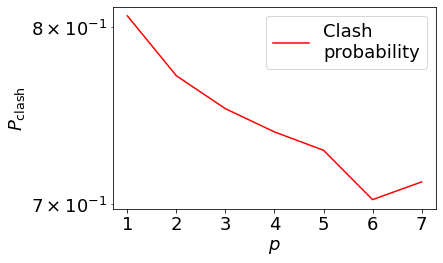

In [10]:
fig, ax = plt.subplots(figsize=(6.5, 4.0))
ax.semilogy(selected_adiabatic_df["p"], selected_adiabatic_df["clash_probability"], "r-", label="Clash\nprobability")
ax.set_xlabel("$p$")
ax.set_ylabel("$P_{\mathrm{clash}}$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(loc="upper right")
fig.tight_layout()
fig.savefig(Path("figures", "small_peptide_sampling", f"energy_optimize_clash_probability__method=adiabatic__num_residues=4.eps"))

### For angles optimized starting from adiabatic schedule

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


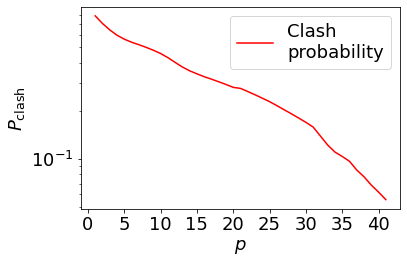

In [11]:
fig, ax = plt.subplots()
ax.semilogy(selected_init_adiabatic_df["p"], selected_init_adiabatic_df["clash_probability"], "r-", label="Clash\nprobability")
ax.set_xlabel("$p$")
ax.set_ylabel("$P_{\mathrm{clash}}$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(loc="upper right")
fig.tight_layout()
fig.savefig(Path("figures", "small_peptide_sampling", f"energy_optimize_clash_probability__method=init_adiabatic__num_residues=4.eps"))

## Extrapolation vs. no extrapolation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


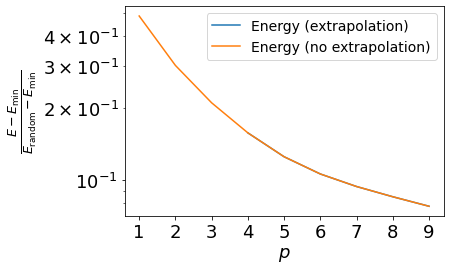

In [12]:
fig, ax = plt.subplots(figsize=(6.6, 4.1))
ax.semilogy(selected_extrap_random_df.query("1 <= p <= 9")["p"], (selected_extrap_random_df.query("1 <= p <= 9")["expected_energy"] - selected_extrap_random_df.query("1 <= p <= 9")["min_energy"]) / (selected_extrap_random_df.query("1 <= p <= 9")["random_sampling_energy"] - selected_extrap_random_df.query("1 <= p <= 9")["min_energy"]), "-", label="Energy (extrapolation)")
ax.semilogy(selected_no_extrap_random_df.query("1 <= p <= 9")["p"], (selected_no_extrap_random_df.query("1 <= p <= 9")["expected_energy"] - selected_no_extrap_random_df.query("1 <= p <= 9")["min_energy"]) / (selected_no_extrap_random_df.query("1 <= p <= 9")["random_sampling_energy"] - selected_no_extrap_random_df.query("1 <= p <= 9")["min_energy"]), "-", label="Energy (no extrapolation)")
ax.set_xlabel("$p$")
ax.set_ylabel("$\\frac{E - E_{\mathrm{min}}}{E_{\mathrm{random}} - E_{\mathrm{min}}}$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(fontsize=14)
fig.tight_layout()
fig.savefig(Path("figures", "small_peptide_sampling", f"energy_optimize_extrap_vs_no_extrap__method=random__num_residues=4.eps"))